### Environment setup for RTL2GDS

RTL2GDS depends on yosys and iEDA. Prebuilt binaries are presented at `/rtl2gds/bin`.

In [ ]:
!pip3 install pyyaml orjson klayout IPython

### Prepare input files

Prepare your RTL design (Verilog files), and configuration (yaml file).

We are using a [Multiplier from openlane2 repo](https://github.com/efabless/openlane2/blob/main/openlane/examples/spm/src/spm.v) as an example.

In [ ]:
%%writefile spm.v
module spm(clk, rst, x, y, p);
    parameter size = 32;
    input clk, rst;
    input y;
    input[size-1:0] x;
    output p;

    wire[size-1:1] pp;
    wire[size-1:0] xy;

    genvar i;

    CSADD csa0 (.clk(clk), .rst(rst), .x(x[0]&y), .y(pp[1]), .sum(p));
    generate for(i=1; i<size-1; i=i+1) begin
        CSADD csa (.clk(clk), .rst(rst), .x(x[i]&y), .y(pp[i+1]), .sum(pp[i]));
    end endgenerate
    TCMP tcmp (.clk(clk), .rst(rst), .a(x[size-1]&y), .s(pp[size-1]));
endmodule

module TCMP(clk, rst, a, s);
    input clk, rst;
    input a;
    output reg s;

    reg z;

    always @(posedge clk or posedge rst) begin
        if (rst) begin
            //Reset logic goes here.
            s <= 1'b0;
            z <= 1'b0;
        end
        else begin
            //Sequential logic goes here.
            z <= a | z;
            s <= a ^ z;
        end
    end
endmodule

module CSADD(clk, rst, x, y, sum);
    input clk, rst;
    input x, y;
    output reg sum;

    reg sc;

    // Half Adders logic
    wire hsum1, hco1;
    assign hsum1 = y ^ sc;
    assign hco1 = y & sc;

    wire hsum2, hco2;
    assign hsum2 = x ^ hsum1;
    assign hco2 = x & hsum1;

    always @(posedge clk or posedge rst) begin
        if (rst) begin
            //Reset logic goes here.
            sum <= 1'b0;
            sc <= 1'b0;
        end
        else begin
            //Sequential logic goes here.
            sum <= hsum2;
            sc <= hco1 ^ hco2;
        end
    end
endmodule

Writing spm.v


In [3]:
%%writefile config.yaml
# design_setting:
DESIGN_TOP: spm

# path_setting:
RTL_FILE: ./spm.v
NETLIST_FILE: ./spm_results/spm.v
RESULT_DIR: ./spm_results
GDS_FILE: ./spm_results/spm.gds

# constrain:
CLK_PORT_NAME: clk
CLK_FREQ_MHZ: "100"
UTILIZATION: "0.5"

Writing config.yaml


### RTL2GDS Flow

There are two ways to run the RTL-to-GDS flow:

1: RTL2GDS Python Module CLI

In [ ]:
!python3 -m rtl2gds -c ./config.yaml

2: RTL2GDS Python API

In [ ]:
from rtl2gds import chip, flow

spm = chip.Chip("spm")
spm.load_config("./config.yaml")

rtl2gds_flow = flow.RTL2GDS(spm)
rtl2gds_flow.run()

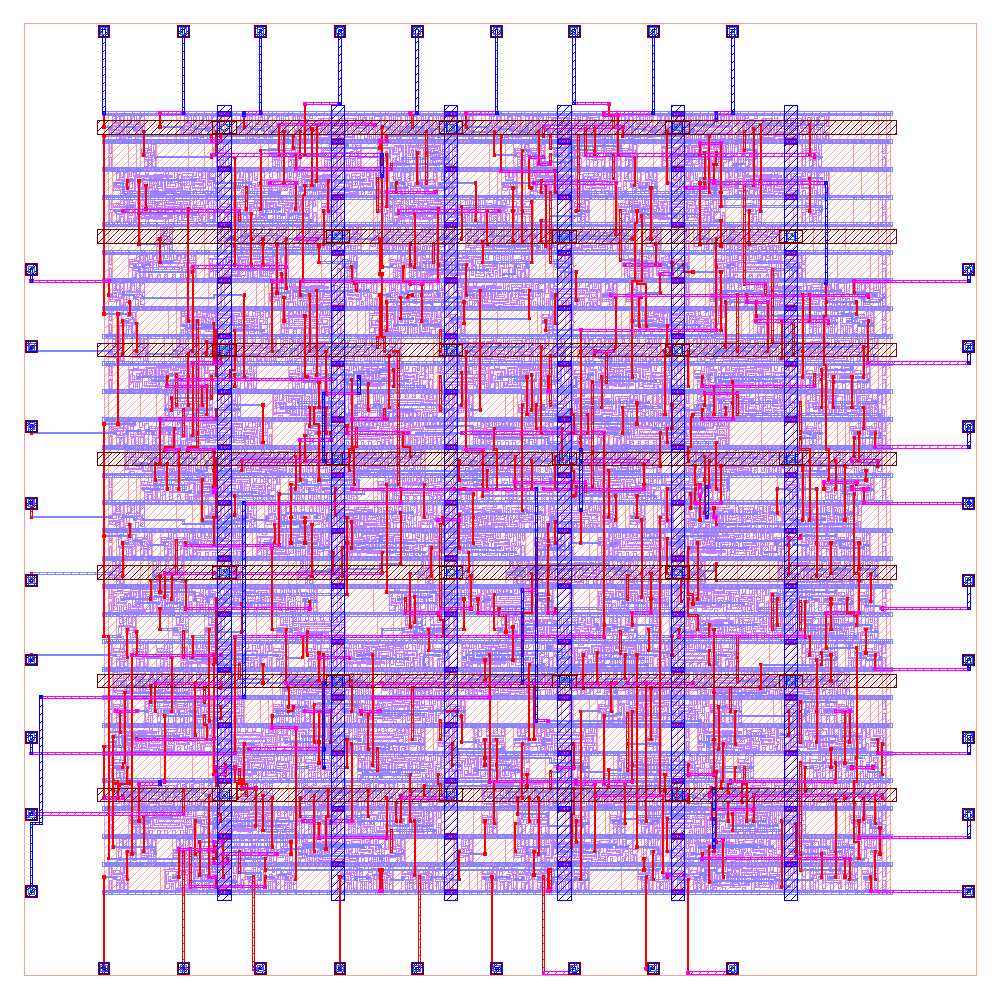

In [5]:
from rtl2gds import step
from IPython.display import Image

gds = './spm_results/spm.gds'
png = "./spm_results/spm.png"

step.save_gds_image(gds, png, 1000, 1000)
Image(png)